### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
%pip install --upgrade transformers datasets accelerate deepspeed
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


/home/mitc/nadejda/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data and model

In [2]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

Repo card metadata block was not found. Setting CardData to empty.




Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [3]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "gchhablani/bert-base-cased-finetuned-qqp",
    use_safetensors=True
)


2025-10-06 16:12:03.447764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-06 16:12:03.474661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-06 16:12:04.234135: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Tokenize the data

In [4]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [5]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 point)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [6]:
import torch
from torch.utils.data import DataLoader
from transformers import default_data_collator

# Load validation set
val_set = qqp_preprocessed["validation"]

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Create optimized DataLoader
val_loader = DataLoader(
    val_set,
    batch_size=64,           # larger batch for speed
    shuffle=False,
    collate_fn=default_data_collator,
    num_workers=4,           # parallel data loading
    pin_memory=True          # faster transfer to GPU
)

correct = 0
total = 0

# Evaluate with no_grad and mixed precision for speed
from torch.cuda.amp import autocast

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["labels"].to(device)

        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            preds = torch.argmax(outputs.logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_accuracy = correct / total
print(f"Validation Accuracy: {val_accuracy:.4f}")


/tmp/ipykernel_815968/212221521.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Accuracy: 0.9084


__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [7]:

accuracy = val_accuracy


In [8]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (4 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


/home/mitc/nadejda/venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_815968/2809102802.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__

Epoch,Training Loss,Validation Loss,Accuracy
1,0.421400,0.324668,0.864500
2,0.247400,0.496383,0.869500


Evaluation: {'eval_loss': 0.3246680200099945, 'eval_accuracy': 0.8645, 'eval_runtime': 2.7863, 'eval_samples_per_second': 717.8, 'eval_steps_per_second': 89.725, 'epoch': 2.0}


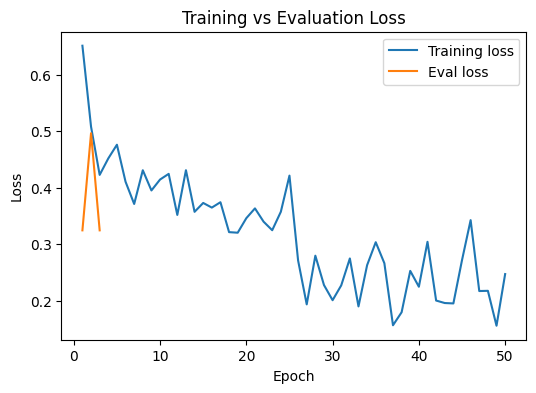

In [9]:
# Install dependencies
!pip install --upgrade -q transformers datasets evaluate sentencepiece accelerate matplotlib

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
import matplotlib.pyplot as plt


dataset = load_dataset("glue", "qqp")


tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")


def tokenize_function(example):
    return tokenizer(example["question1"], example["question2"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in tokenized_datasets["train"].column_names if col not in ["input_ids", "token_type_ids", "attention_mask", "label"]]
)


small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(2000))


model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)


metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=50,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


train_result = trainer.train()


metrics = trainer.evaluate()
print("Evaluation:", metrics)


logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, label="Training loss")
if len(eval_loss) > 0:
    plt.plot(range(1, len(eval_loss)+1), eval_loss, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Evaluation Loss")
plt.show()


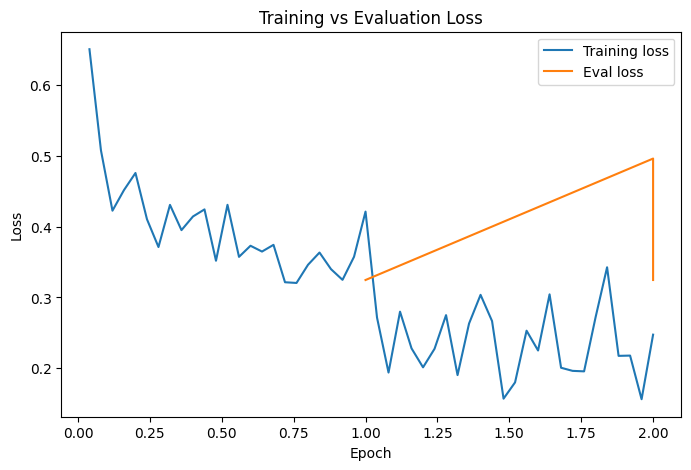

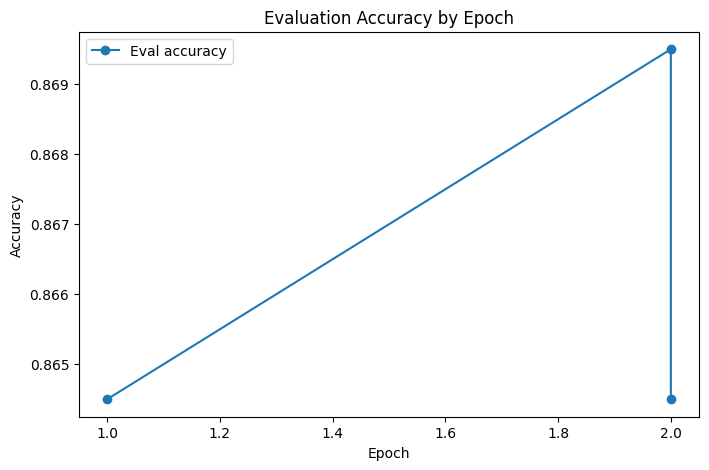

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
df = pd.DataFrame(log_history)

df_train = df[df["loss"].notna()]
df_eval = df[df["eval_loss"].notna()]

plt.figure(figsize=(8,5))
plt.plot(df_train["epoch"], df_train["loss"], label="Training loss")
plt.plot(df_eval["epoch"], df_eval["eval_loss"], label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.show()

if "eval_accuracy" in df_eval:
    plt.figure(figsize=(8,5))
    plt.plot(df_eval["epoch"], df_eval["eval_accuracy"], marker='o', label="Eval accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy by Epoch")
    plt.legend()
    plt.show()


### Task 3: try the full pipeline (1 point)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

In [11]:
from tqdm import tqdm
from torch.nn.functional import softmax
import torch

def find_top5_duplicates(query, model, tokenizer, raw_train_dataset, top_k=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    
    scores = []
    for q in tqdm(raw_train_dataset['question1'][:2000]): 
        inputs = tokenizer(
            query,
            q,
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = softmax(outputs.logits, dim=1)
            score = probs[0][1].item() 
            scores.append((q, score))

    top5 = sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]
    return top5


from datasets import load_dataset
qqp_raw = load_dataset("glue", "qqp") 

query = "How can I improve my English speaking skills?"
top5_duplicates = find_top5_duplicates(query, model, tokenizer, qqp_raw['train'])

for i, (q, score) in enumerate(top5_duplicates, 1):
    print(f"{i}. {q} (duplicate probability: {score:.4f})")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 166.63it/s]

1. How can I increase my English fluency? (duplicate probability: 0.9596)
2. How should I improve my english communication skills? (duplicate probability: 0.9593)
3. How can I improve my English grammar? (duplicate probability: 0.9579)
4. How can I upgrade my English Writing skills? (duplicate probability: 0.9564)
5. How can I improve my English speaking ability? (duplicate probability: 0.9551)


__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.